Machine Learning (M124) - Homework 2

<u>Student credentials</u><br>
**FullName:** Spanos Nikolaos<br>
**Student AM:** 7115112100023<br>
**Student email:** cs2210023@di.uoa.gr <br><br>


**Supervisor(s):** Associate Professor Panagakis G., Panousis K. PhD<br>
*All rights reserved from National and Kapodistrian University of Athens, Department of Computer Science (DI)*

Athens, Greece, May 2023

In [ ]:
import cv2
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import joblib
import pickle
import time
import datetime

from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import mnist

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Question 1: Face Recognition

#### i. Load images into a specific set/sample

In [ ]:
def loadImages(images_path, set_number):
  """
  Definition
  ---------
  Load a set of images from local path to a pandas dataframe. The rows are the total images, and the columns are the n*n pixels of the image. For example, if an image is 50x50 pixels then the dataframe will have 2500 columns/features.

  Arguments
  ---------
  images_path: Parent directory of images.
  set_number: The set/group of images to load.

  Output
  ---------
  The pandas dataframe with the set of images loaded in tabular format. Each image is represented by a vector of n*n = n^2 dimentions.
  The table has shape of X*N^2, where X = total number of images in the set and N^2 are the 1-D arrays representing the pixels of the photos.
  """
  img_number = []
  person_number = list(range(1,11))
  generated_df = pd.DataFrame()
  target_value = []
  if set_number == "Set_1":
    img_number = list(range(1,8))
  elif set_number == "Set_2":
    img_number = list(range(8,20))
  elif set_number == "Set_3":
    img_number = list(range(20,32))
  elif set_number == "Set_4":
    img_number = list(range(32,46))
  elif set_number == "Set_5":
    img_number = list(range(46,65))
  else:
    raise TypeError("Wrong input for argument 'set_number'. Correct values are Set_1, Set_2, etc")
  for person in person_number:
    for pic in img_number:
      if person < 10 and pic < 10:
        img_path = f"{images_path}/person0{person}_0{pic}.png"
      elif person < 10 and pic >= 10:
        img_path = f"{images_path}/person0{person}_{pic}.png"
      elif person >= 10 and pic < 10:
        img_path = f"{images_path}/person{person}_0{pic}.png"
      else:
        img_path = f"{images_path}/person{person}_{pic}.png"
      #Vectorize image using the cv2 module.
      img = cv2.imread(img_path,0)
      #Tabular format of the vectorized image.
      df = pd.DataFrame(img.flatten().reshape(1,-1))
      #Append the tabular vector to the general table with all the images from the set.
      generated_df = pd.concat([generated_df, df],axis = 0)
      #Append the target tag for the image (to which person it belongs).
      target_value.append(int(img_path.split("/")[-1].split("_")[0][-2:]))
    generated_df["target"] = target_value
    generated_df.reset_index(drop=True, inplace=True)
  return generated_df

In [ ]:
# Load the images from the first set (Set_1) and create two numpy arrays (X_train, y_train) with the features, labels respectively.
df = loadImages("drive/MyDrive/ComputerScience/MachineLearning/HW2/faces","Set_1")
print(df)
X_train, y_train = (df.iloc[:,:-1].values), (df.iloc[:,-1].values)

      0    1    2    3    4    5    6    7    8    9  ...  2491  2492  2493  \
0    94  114  115  114  106  102  113  114  130  142  ...    99    96   109   
1    93  109  112  104  101  102  119  125  134  149  ...   118   127   134   
2    85   97  104   98  105   96  110  109  110  126  ...    88    88    97   
3   111  126  134  123  124  124  140  127  142  163  ...    96    98   109   
4   115  130  144  131  144  130  157  134  142  160  ...    92    93   103   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
65   77   74   82   96  109  106  125  123  114  119  ...   126   122   118   
66  110   99  105  122  137  143  155  160  156  138  ...   136   146   137   
67  121  115  124  138  160  158  178  179  159  162  ...   127   132   119   
68   72   65   73   87  106   97  123  129  121  124  ...   169   171   173   
69  140  134  139  155  174  182  192  200  178  178  ...   130   135   122   

    2494  2495  2496  2497  2498  2499  target  
0 

#### ii. Develop and train the Eagenface algorithm

##### Decomposing the steps of the eigenface application

**Step 1:** Normalize the data by substracting the mean value of the images and divide by their standard deviation.

**Step 2:** Apply PCA algorithm.

* Step 2.1: Compute the covariance matrix of the normalized table.

* Step 2.2: Calculate the eigenvalues, eigenvectors of the covariance matrix.

* Step 2.3: Project the standardized data to the eigenvectors generated from the covariance matrix.

* Step 2.4: Normalize eigenvectors. Normalizing the eigenvectors (i.e., dividing each vector by its norm) ensures that they all have the same length, which is important for comparing their relative contributions to the variance in the data. Without normalization, eigenvectors with larger norms would appear to capture more variance in the data, even if they actually contribute less to the overall variance. Thus, by normalizing the eigenvectors, we ensure that each component captures an equal amount of variance, making it easier to interpret and compare their contributions to the data.

* Step 2.5: Select the top/first N eigenvectors/eigenvalues. For this experiment I will use two different d values, with d corresponding to the number of top eigenvalues/vectors. $d=9, d=30$.

**Step 3:** Project the data matrix $A$ onto the space created by the top N eigenvectors. Basically, compute the dot product of the eigenvectors (top d-dimentional features) and the normalized table. Apply $A*d$

**Step 4:** Apply K-Neighbor classifier to select the nearest image/neighbor based on the training samples and the pca-transformed featues.

In [ ]:
def pca(X, d):
  """
  Definition
  ---------
  Apply the PCA algorithm methodology using linear algebra and matrix calculations.

  Arguments
  ---------
  X : Array-like of shape (n_samples, n_components). The training features to apply the dimentionality reduction algorithm.
  d : The top N features to select for dimentionality reduction.

  Output
  ---------
  eigenvectors: The top principal components generated after applying PCA on X-array.
  mean: The mean value of the training features. Shape (n_samples, 1).
  std: The standard deviation of the training features. Shape (n_samples, 1).
  """
  #standardize data samples
  mean =  np.mean(X, axis = 1).reshape(-1,1)
  std = np.std(X, axis = 1).reshape(-1,1)
  X = (X - mean)/std
  print("Normalized result for the first image", X[0])

  CovMatrix = np.matmul(X, X.T) #option 1: return a matrix with a shape equal to M, where (M, M) = total number of images
  #CovMatrix = np.cov(X.T, bias=False) #option 2: return a matrix of shape (N, N) = total number of observatations (i.e. pixels)

  #print("\nCovariance matrix C: ", CovMatrix[0])

  eigenvalues, eigenvectors = np.linalg.eig(CovMatrix) # Note that eagenvalues are sorted in descending order. From the largest eigenvalue to the smallest

  print(f"\nInitial eigenvalues shape: {eigenvalues.shape}")
  print(f"\nInitial eigenvectors shape: {eigenvectors.shape}")

  eigenvectors = np.matmul(X.T, eigenvectors)
  norms = np.linalg.norm(eigenvectors, axis=0)
  eigenvectors = eigenvectors / norms

  #print(f"\nNorm values of the eigenvectors: {norms}")
  #print(f"\nNorm shape: {norms.shape}")

  # sort the eigenvectors in descending order based on their corresponding eigenvalues
  eig_pairs = [(eigenvalues[i], eigenvectors[:, i]) for i in range(len(eigenvalues))]
  eig_pairs.sort(reverse=True, key=lambda x: x[0])

  # choose d eigenvectors with the largest eigenvalues
  if d > 0:
    eigenvectors = np.array([eig_pairs[i][1] for i in range(d)]) #shape = (N, d), where N = n_features.

  #print(f"Top {d} eigenvectors: {eigenvectors}")
  print(f"\nEigenvectors shape after selecting top N components: {eigenvectors.shape}")

  return eigenvectors.T, mean, std

def project_images(weights, X, mean, std):
  """
  Definition
  ---------
  Project the images in the eigenspace by transforming the X features (original images) to the eigenvectors selected from the PCA algorithm.

  Arguments
  ---------
  weights : Parent directory of images.
  X : Array-like of the pixels per image groouped in a matrix of shape (n_samples, n_components), where n_samples = total images/observations, and n_components = total columns/pixels (NxN = 50x50 = 2500 in this example).
  mean : The mean values per image.
  std : The standard deviation per image.

  Output
  ---------
  X_transformed : array-like of shape (n_samples, n_components). Projection of the original table in the first principal components. 
  N_samples is the total observations/samples (i.e. 70 images in Set_1) and n_components is d-dimentional matrix of eigenvectors (i.e. (70,9)). Thus, from 2500 features down to 9, 30 or N total features.
  """

  X = (X - mean)/std
  # X_transformed = np.matmul(weights, X)
  X_transformed = np.dot(X, weights)
  print(f"\nShape of the transformed X samples after PCA: {X_transformed.shape}")
  
  return X_transformed

def train_eigenfaces(X_train, y_train, n_neighbors =10):
  """
  Definition
  ---------
  Train the eigenfaces algorithm on the training samples using the k Nearest Neighbors of an image based on the weights/eigenvectors from the PCA transformation. Then select the closest neighbor from those selected.
  This function uses the KNeighborsClassifier from Python's sklearn module found here: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

  Arguments
  ---------
  X : Array-like: The trainable features projected into the eigenspace.
  y : Array-like: The target labels of the trainable images.
  n_neighbors : The number of closest neighbors to select.

  Output
  ---------
  knn_classifier : Trained KNN classifier.
  """
  #initialize classifier
  knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
  #fit classifier on training samples
  knn_classifier.fit(X_train, y_train)
  
  return knn_classifier

def evaluate_eigenfaces(knn_classifier, weights, parent_path, oss_images):
  """
  Definition
  ---------
  Train the eigenfaces algorithm on the training samples using the k Nearest Neighbors of an image based on the weights/eigenvectors from the PCA transformation. Then select the closest neighbor from those selected.
  This function uses the KNeighborsClassifier from Python's sklearn module found here: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

  Arguments
  ---------
  knn_classifier : Sklean classifier object. The trained KNN classifier on eigenfaces.
  weights : Array-like: The dimentionally reduced eigen vectors to maltiply with the out-of-sample values and create the test matrix.
  parent_path: The parent folder with all the images (1st argument) used in function loadImages().
  oss_images : The path of the samples to be used in the evaluate of the eigenface trained algorithm. This argument is basically the set_number (2nd argument) used in the function loadImages().

  Output
  ---------
  Message: Evaluation completed
  """
  #load out-of-sample images
  oos = loadImages(parent_path, oss_images)
  X_test, y_test = (oos.iloc[:,:-1].values), (oos.iloc[:,-1].values)

  #standardize images
  mean =  np.mean(X_test, axis = 1).reshape(-1,1)
  std = np.std(X_test, axis = 1).reshape(-1,1)
  X_test = (X_test - mean)/std

  #transform X_test based on the pca components
  X_transformed = np.dot(X_test, weights)

  #get predictions
  y_pred = knn_classifier.predict(X_transformed)

  #get accuracy score
  accuracy = accuracy_score(y_test, y_pred)
  print(f"\nAccuracy on set: {oss_images}: {accuracy:.2%}")

  total_correct = 0
  total_wrong = 0
  for i in range(len(y_test)):
    if y_test[i] == y_pred[i]:
      total_correct += 1
    else:
      total_wrong += 1

  print(f"\nTotal correct predictions on set {oss_images} : {total_correct}")
  print(f"Total wrong predictions on set {oss_images} : {total_wrong}")

def eigenface_algorithm(X_train, y_train, d, parent_dir):
  """
  Definition
  ---------
  Apply the eigenface algorithm for different value of the parameter d. The default training sample is derived explicitely from the first set of images (Set_1). 
  After the classifier is trained the method evaluates the classifier predictive power on out-of-samples images from the other sets (Set_2, Ste_3, Set_4, Set_5).

  Arguments
  ---------
  X_train : Array-like of shape (n_samples, n_features): The images of the first set in a pixel-size tabular format.
  y_train : Array-like: The target labels of the images.
  d : The pca-components to select for transforming the data into a lower-dimentional space.
  parent_path: The parent folder with all the images (1st argument) used in function loadImages().

  Output
  ---------
  weights: The top N eigenvectors
  mean: The mean value of the images in the training sample
  std: The standard deviation of the images in the training sample
  """
  #1. Get the pca components
  weights, mean, std = pca(X_train, d) #get dimentionality reduction components

  #2. Tranform training sample using the pca components
  X_projection = project_images(weights, X_train, mean, std) #we expect the shape of the transformed df to be equal to (70,d) where 70 are the total images in the training sample and d = top N principal components.

  #3. Cross-calidation to select optimal number of neighbors for KNN classifier
  k_list = list(range(1, 31))
  cv_scores = []
  for neighbor in k_list:
    knn_trained_model = KNeighborsClassifier(n_neighbors=neighbor)
    scores = cross_val_score(knn_trained_model, X_projection, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

  print("\n")
  plt.plot(k_list, cv_scores)
  plt.xlabel("Number of Neighbors K")
  plt.ylabel("Cross-validation Accuracy per K-value")
  plt.title("Select optimal value for k-neighbor parameter")
  plt.show()

  optimal_k = k_list[cv_scores.index(max(cv_scores))]
  print("\nThe optimal number of neighbors is", optimal_k)

  #4. Train knn-classifier with the optimal value of neighbors after cross-validation
  knn_trained_model = train_eigenfaces(X_projection, y_train, optimal_k)

  #5. Evaluate trained classifer by predicting the target label of out-of-sample images
  iterations_array = [f"Set_{i+1}" for i in range(5)]

  for i in iterations_array:
    print(f"\niteration for sample: {i}")
    evaluate_eigenfaces(knn_trained_model, weights, parent_dir, i)
    print("--------------------------------------------------------------")

  return weights

def reconstruct_image(eigenvectors, parent_path, image_set, randon_image_idx):
  #load selected set of images
  loaded_set = loadImages(parent_path, image_set)
  X, y = (loaded_set.iloc[:,:-1].values), (loaded_set.iloc[:,-1].values)

  #standardize original image
  mean =  np.mean(X, axis = 1).reshape(-1,1)
  std = np.std(X, axis = 1).reshape(-1,1)
  img = (X[randon_image_idx] - mean[randon_image_idx])/std[randon_image_idx]

  #transform standardized image using eigenface weights
  transformed = np.dot(img, eigenvectors)

  #reconstruct image
  reconstructed = (np.dot(transformed, eigenvectors.T).flatten() + mean[randon_image_idx])* std[randon_image_idx]

  #reshape the reconstructed + original images
  image_shape = (int(np.sqrt(X[randon_image_idx].shape[0])), int(np.sqrt(X[randon_image_idx].shape[0])))

  reconstructed = reconstructed.reshape(image_shape)
  original = X[randon_image_idx].reshape(image_shape)

  #convert the reconstructed + original images to uint8
  reconstructed = np.uint8(reconstructed)
  original = np.uint8(original)

  plot_array=[]
  plot_array.append((original,'original'))
  plot_array.append((reconstructed,'reconstructed'))

  #plot the original + reconstructed images
  fig, axes = plt.subplots(1, len(plot_array), figsize=(6, 2))
  for i, axis in enumerate(axes):
    axis.imshow(plot_array[i][0], cmap='gray')
    axis.axis('off')
    if plot_array[i][1] == 'original':
      axis.set_title(f'Original image')
    else:
      axis.set_title(f'Reconstructed image')
  plt.show()

def svd(X, d):
  """
  Definition
  ---------
  Apply the Singular Value Decomposition (SVD) algorithm methodology using linear algebra.

  Arguments
  ---------
  X : Array-like of shape (n_samples, n_components). The training features to apply the dimentionality reduction algorithm.
  d : The top N features to select for dimentionality reduction.

  Output
  ---------
  U: Left singular vector of image, it represents the column space of the image.
  S: Diagonal matrix with non-negative real numbers on the diagonal. 
  V: Right singular vector of image, it represents the row space of the image.
  """
  #standardize data samples
  mean =  np.mean(X, axis = 1).reshape(-1,1)
  std = np.std(X, axis = 1).reshape(-1,1)
  X = (X - mean)/std

  #compute SVD
  U, S, V = np.linalg.svd(X)
  S = np.diag(S)

  #select top d singular vectors.
  U_reduced = U[:,:d]
  S_reduced = S[0:d, :d]
  V_reduced = V[:d, :]

  return U_reduced, S_reduced, V_reduced

#### Identify the target label of out-of-sample imahges using the trained KNN algorithm for d=9

Normalized result for the first image [-0.67775773 -0.04894665 -0.0175061  ... -1.2436877  -1.52665268
 -1.43233102]

Initial eigenvalues shape: (70,)

Initial eigenvectors shape: (70, 70)

Eigenvectors shape after selecting top N components: (9, 2500)

Shape of the transformed X samples after PCA: (70, 9)




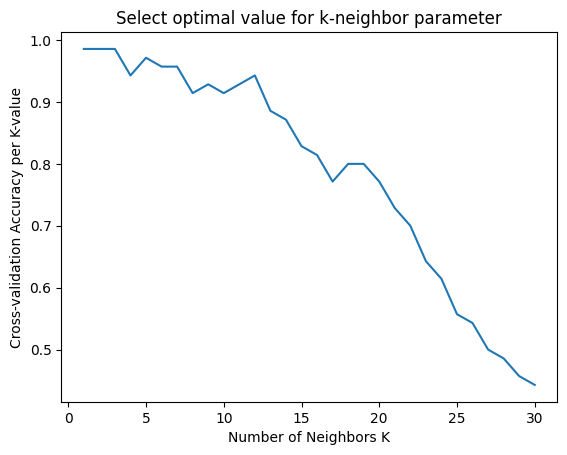


The optimal number of neighbors is 1

iteration for sample: Set_1

Accuracy on set: Set_1: 100.00%

Total correct predictions on set Set_1 : 70
Total wrong predictions on set Set_1 : 0
--------------------------------------------------------------

iteration for sample: Set_2

Accuracy on set: Set_2: 99.17%

Total correct predictions on set Set_2 : 119
Total wrong predictions on set Set_2 : 1
--------------------------------------------------------------

iteration for sample: Set_3

Accuracy on set: Set_3: 67.50%

Total correct predictions on set Set_3 : 81
Total wrong predictions on set Set_3 : 39
--------------------------------------------------------------

iteration for sample: Set_4

Accuracy on set: Set_4: 28.57%

Total correct predictions on set Set_4 : 40
Total wrong predictions on set Set_4 : 100
--------------------------------------------------------------

iteration for sample: Set_5

Accuracy on set: Set_5: 16.32%

Total correct predictions on set Set_5 : 31
Total wrong

In [ ]:
eigenface_weights_a = eigenface_algorithm(X_train, y_train, 9, "drive/MyDrive/ComputerScience/MachineLearning/HW2/faces")

Normalized result for the first image [-0.67775773 -0.04894665 -0.0175061  ... -1.2436877  -1.52665268
 -1.43233102]

Initial eigenvalues shape: (70,)

Initial eigenvectors shape: (70, 70)

Eigenvectors shape after selecting top N components: (30, 2500)

Shape of the transformed X samples after PCA: (70, 30)




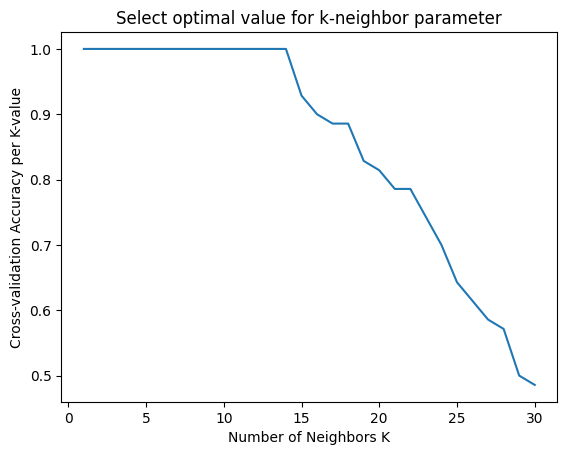


The optimal number of neighbors is 1

iteration for sample: Set_1

Accuracy on set: Set_1: 100.00%

Total correct predictions on set Set_1 : 70
Total wrong predictions on set Set_1 : 0
--------------------------------------------------------------

iteration for sample: Set_2

Accuracy on set: Set_2: 100.00%

Total correct predictions on set Set_2 : 120
Total wrong predictions on set Set_2 : 0
--------------------------------------------------------------

iteration for sample: Set_3

Accuracy on set: Set_3: 95.00%

Total correct predictions on set Set_3 : 114
Total wrong predictions on set Set_3 : 6
--------------------------------------------------------------

iteration for sample: Set_4

Accuracy on set: Set_4: 43.57%

Total correct predictions on set Set_4 : 61
Total wrong predictions on set Set_4 : 79
--------------------------------------------------------------

iteration for sample: Set_5

Accuracy on set: Set_5: 22.11%

Total correct predictions on set Set_5 : 42
Total wrong

In [ ]:
eigenface_weights_b = eigenface_algorithm(X_train, y_train, 30, "drive/MyDrive/ComputerScience/MachineLearning/HW2/faces")

#### iii. Plot the top 9 eigenvectors after training the eigenface algorithm for Set_1.
* a. What you observe?
* b. What is expressed by each eigenvector?

(9, 2500)


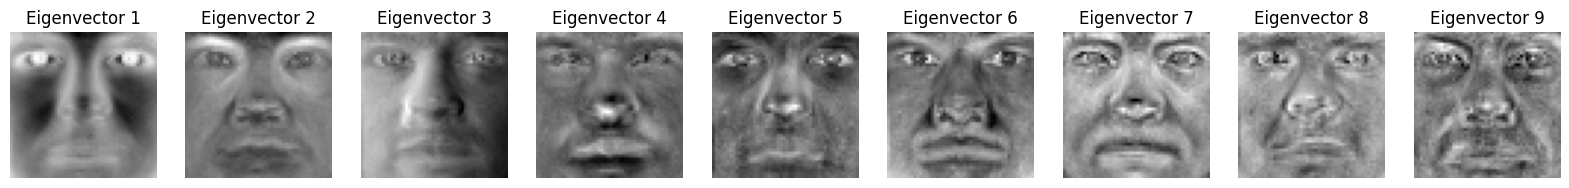

In [ ]:
#Plot the 9 eigenvectors extracted from the Eigenface algorithm
print(eigenface_weights_a.T.shape)
image_shape = (50, 50)
reshaped_eigenvectors = np.reshape(eigenface_weights_a.T, (eigenface_weights_a.shape[1], *image_shape))

fig, axes = plt.subplots(1, eigenface_weights_a.shape[1], figsize=(20, 4))
for i, axis in enumerate(axes):
  axis.imshow(reshaped_eigenvectors[i], cmap='gray')
  axis.axis('off')
  axis.set_title(f'Eigenvector {i+1}')
plt.show()

It's clear that the 9 selected vectors can clearly potray 9 faces by selecting the 9 most important eigenvectors. Each eigenvector clearly depicts a whole face and we can clearly distinguish the eyes, the nose, the mouse and even the eyebrows of the face. The eigenvectors represent the directions of maximum variance of the training samples. This direction is known as principal component. 

Each eigenvector corresponds to a principal component, which is a linear combination of the original variables that captures the most variation in the dataset. Also, each eigenvalue corresponds to the amount of variance explained by each eigenvector. If I divide each eigenvalue by the `sum()` of all eigenvalues I can determine the proportion of variance explained by the eigenvectors.

#### iv. Use the d=9 and d=30 Eigenfaces from Set_1 to reconstruct a random image from each of the different 5 Sets.
* a. Plot the original and the reconstructed image.
* b. Comment on the results.

1. Plot the image on index 17 (so the 18th image) from Set_1 using the eigenfaces with 9 dimentions.

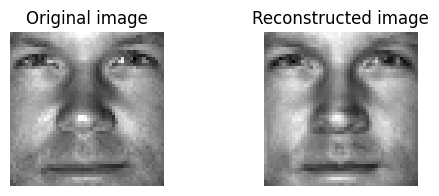

In [ ]:
reconstruct_image(eigenface_weights_a, "drive/MyDrive/ComputerScience/MachineLearning/HW2/faces", "Set_1", 17)

The recostructed image is almost identical to the original.

2. Plot the image on index 5 (so the 6th image) from Set_2 using the eigenfaces with 9 dimentions.

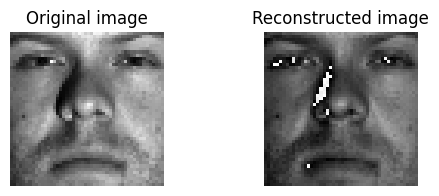

In [ ]:
reconstruct_image(eigenface_weights_a, "drive/MyDrive/ComputerScience/MachineLearning/HW2/faces", "Set_2", 6)

The recostructed image is alost identical to the original.

3. Plot the image on index 18 (so the 19th image) from Set_3 using the eigenfaces with 9 dimentions.

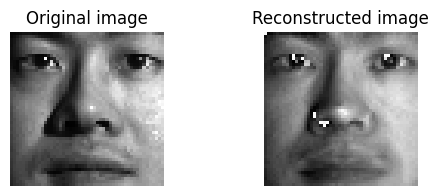

In [ ]:
reconstruct_image(eigenface_weights_a, "drive/MyDrive/ComputerScience/MachineLearning/HW2/faces", "Set_3", 18)

4. Plot the image on index 51 (so the 52th image) from Set_4 using the eigenfaces with 9 dimentions.

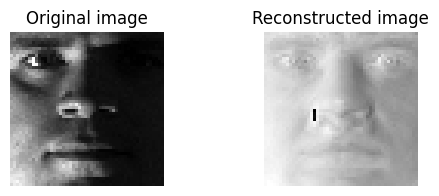

In [ ]:
reconstruct_image(eigenface_weights_a, "drive/MyDrive/ComputerScience/MachineLearning/HW2/faces", "Set_4", 51)

Many more disimilarities between the two images. It's expected since the knn classifier had a very poor performance on this set with a 28.57% accuracy.

5. Plot the image on index 88 (so the 89th image) from Set_5 using the eigenfaces with 9 dimentions.

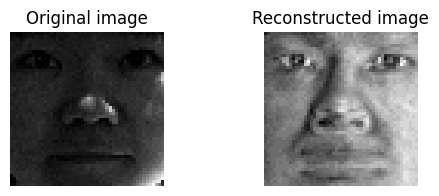

In [ ]:
reconstruct_image(eigenface_weights_a, "drive/MyDrive/ComputerScience/MachineLearning/HW2/faces", "Set_5", 89)

Many more disimilarities between the two images. It's expected since the knn classifier had a very poor performance on this set with a 16.32% accuracy.

---
Next I plot the same images as previously but now with using the eigenfaces of 30 dimentions.

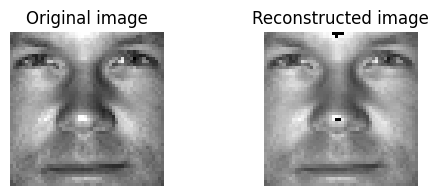

In [ ]:
reconstruct_image(eigenface_weights_b, "drive/MyDrive/ComputerScience/MachineLearning/HW2/faces", "Set_1", 17)

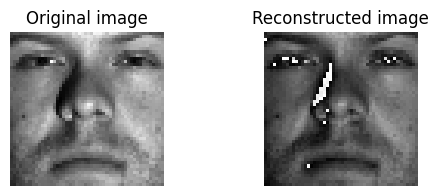

In [ ]:
reconstruct_image(eigenface_weights_b, "drive/MyDrive/ComputerScience/MachineLearning/HW2/faces", "Set_2", 6)

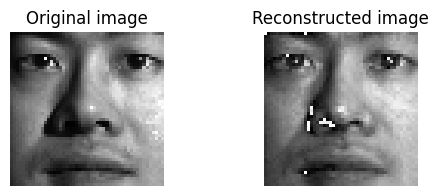

In [ ]:
reconstruct_image(eigenface_weights_b, "drive/MyDrive/ComputerScience/MachineLearning/HW2/faces", "Set_3", 18)

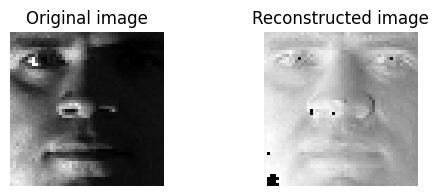

In [ ]:
reconstruct_image(eigenface_weights_b, "drive/MyDrive/ComputerScience/MachineLearning/HW2/faces", "Set_4", 51)

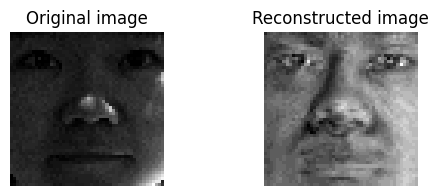

In [ ]:
reconstruct_image(eigenface_weights_b, "drive/MyDrive/ComputerScience/MachineLearning/HW2/faces", "Set_5", 89)

The first three sets have almost the same image to the original. Greater accuracy in the image details achieved after using 30 dimentions. Even in the more inaccurate Set(s) 4 and 5 the reconstructed images have more similarities with their original form compared to previous eigenfaces of 9 dimentions.

#### v. Plot the 9 singular vectors after applying the SVD methodology on the data matrix of Set_1.
* a. Do you observe any difference in the *Singular Vectors* from the *Eigenvectors*?
* b. If yes? Why?

In [ ]:
U, S, V = svd(X_train, 9)

$U, V $ = Orthogonal matrices representing a rotation factor for the original matrix $X$. With $US representing a column-wise rotation and $V$ a row-wise rotation.

$D$ = Diagonal matrix of singular values. Representing a scaling factor.

SVD aims to express the original matrix as a linear combination for low-rank matrices.

In [ ]:
U.shape,S.shape,V.shape #X = UΣV^T

((70, 9), (9, 9), (9, 2500))

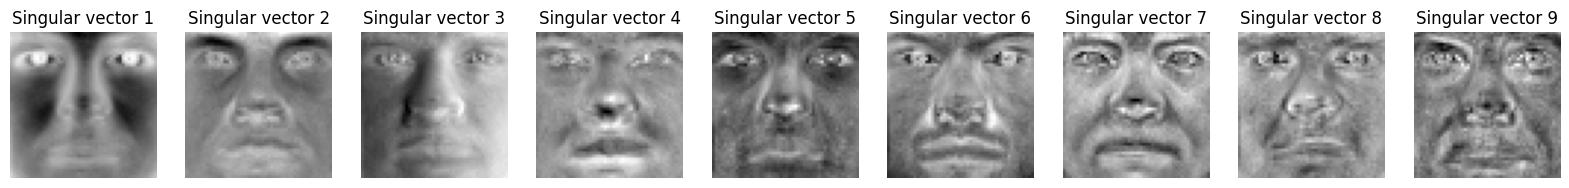

In [ ]:
fig, axes = plt.subplots(1, V.shape[0], figsize=(20, 4))
for i, axis in enumerate(axes.flatten()):
    image_shape = (50, 50)
    singular_vector_image = V[i].reshape(*image_shape)
    axis.imshow(singular_vector_image, cmap="gray")
    axis.axis("off")
    axis.set_title(f'Singular vector {i+1}')
plt.show()

5 out of 9 vectors/components are identical. The rest 4 of them (specifically, vectors 2, 3, 4, 6) are very close to each other with some differences in the image lightning or face position/angle.

This similarity between the PCA components and SVD singular vectors is expected since both techniques aim to the eigendecomposition of a matrix. From one hand, PCA decomposes a Covariance matrix, while SVD performs a matrix factorization of any matrix, including a Covariance matrix too.

The columns of the $V$ matrix computed by the SVD vectors are a stretched representation of the eigenvectors obtained from the covariance matrix $C$ of PCA approach. And the singular values of matrix $Σ$ are related to the eigenvalues of $C$, where SVD computes $X = UΣV^T$ and PCA computes the covariance matrix $C = (X - X̄)^T(X - X̄)$, with $X̄ =$ mean of $X$.

In [ ]:
V[0]

array([0.03636842, 0.03654541, 0.03531635, ..., 0.02084395, 0.02787873,
       0.03249515])

In [ ]:
eigenface_weights_a[0]

array([ 0.03636842, -0.02822441,  0.01817649,  0.03808102, -0.00838933,
       -0.0296356 , -0.02601027,  0.02181826, -0.00424789])

The elements of $V$ are in the same scale and almost similar to the eigenvectors of PCA algorithm.

The code and the idea of plotting the graphs below are taken from this insightful video here: https://youtu.be/H7qMMudo3e8

In [ ]:
U, S, V = svd(X_train, 60)

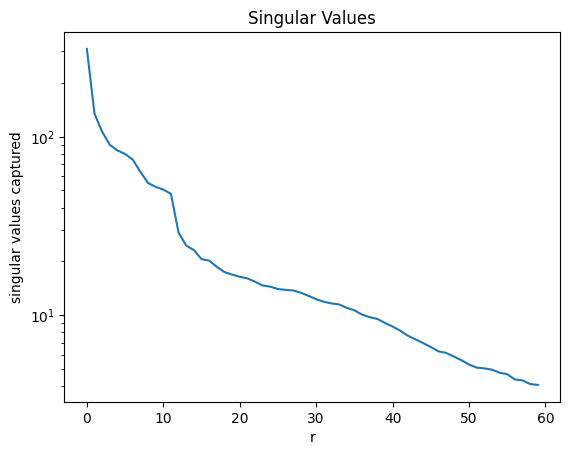

In [ ]:
plt.figure()
plt.semilogy(np.diag(S))
plt.title("Singular Values")
plt.xlabel("r")
plt.ylabel("singular values captured")
plt.show()

From the first graph above, we can observe that even with a very small number of singular vectors (almost 5) we can capture most of the energy explained hitting very high singular vectors (log scale).

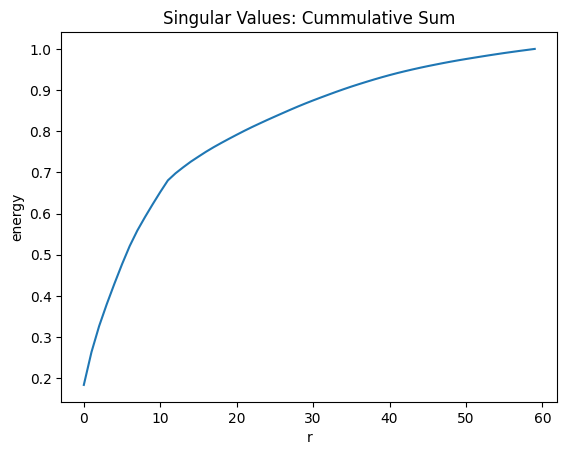

In [ ]:
plt.figure(2)
plt.plot(np.cumsum(np.diag(S))/np.sum(np.diag(S)))
plt.title("Singular Values: Cummulative Sum")
plt.xlabel("r")
plt.ylabel("energy")
plt.show()

Similarly to the first graph, the second one offers an insight about the cummulative percentage of energy captured from the singular vectors. With almost 10 of them we capture about 70% of the energy/variance of the original matrix.

### Question 2: Image Classification using Support-Vector Machines (SVM)

#### Import images

In [ ]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Print the shape of the training set
print("Training set shape:", x_train.shape)

# Print the shape of the test set
print("Test set shape:", x_test.shape)

# Flatten the elements of each image digit
x_train = np.array([x.flatten() for x in x_train])
x_test = np.array([x.flatten() for x in x_test])

print("\nTraining set flattened shape:", x_train.shape)
print("Test set flattened shape:", x_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
Training set shape: (60000, 28, 28)
Test set shape: (10000, 28, 28)

Training set flattened shape: (60000, 784)
Test set flattened shape: (10000, 784)


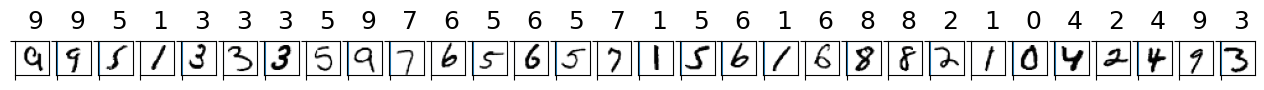

In [ ]:
# Show some randomly chosen images from the traininng set.
# Code snippet got from Microsoft Documentation here: https://learn.microsoft.com/en-us/azure/open-datasets/dataset-mnist?tabs=azureml-opendatasets
count = 0
sample_size = 30
plt.figure(figsize=(16, 6))
for i in np.random.permutation(x_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(x_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

#### Scale in range [0,1] 

For this task I will use the MinMaxScaler() function setting the feature_range to [0,1]. This way I will normalize the data to have mean =0 and unit variance

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_train_normalized = scaler.fit_transform(x_train)
x_test_normalized = scaler.fit_transform(x_test)

#### Check class imbalance for an accurate split of training and validation samples

In [ ]:
# Compute the frequency table
unique_elements, counts = np.unique(y_train, return_counts=True)

# Combine the unique elements and counts into a dictionary
frequency_table = dict(zip(unique_elements, (counts)))

print(frequency_table)

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


It's clear that the data per label/class are not balanced. For example, the image with the most digits is the number "1" and the last digit with the least images is number "4". Thus, while training the SVM classifier I should keep this imbalance in the samples.

Split the dataset for training and validation with a ratio 80-20%.
* 80% of 60,000 samples = 48,000 for training
* 20% of 60,000 samples = 12,000 for validation

I will also suffle the samples to avoid any ordering in the labels of the training samples

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train_normalized,
    y_train,
    shuffle=True,
    test_size=0.2,
    random_state=np.random.RandomState(0),
    stratify = y_train #this parameter will ensure that the labels in the training sample are distributed with the same original ratio (i.e. number "1" will have the most samples and number "4" the least.) 
)

print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_val.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_val.shape)

x_train shape:  (48000, 784)
x_test shape:  (12000, 784)
y_train shape:  (48000,)
y_test shape:  (12000,)


Training SVM classifier with *RBF (Radial Basis Function) kernel*
---

In [ ]:
random_seed = np.random.RandomState(1)
best_accuracy = 0
best_C = None
best_gamma = None
best_param_dict = {}
BASE_DIR = "drive/MyDrive/ComputerScience/MachineLearning/HW2/"

In [ ]:
# Define the hyperparameters to iterate over
C_values = [0.1, 1, 10]
gamma_values = [0.001, 0.01, 0.1]

# Iterate over different combinations of hyperparameters
for C in C_values:
  for gamma in gamma_values:
    svm_rbf = SVC(C = C, gamma = gamma, decision_function_shape = 'ovr', kernel = 'rbf', verbose=4, random_state=random_seed)
    svm_rbf.fit(x_train, y_train)
    y_pred = svm_rbf.predict(x_val)
    accuracy = accuracy_score(y_val, y_pred)
    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_C = C
      best_gamma = gamma
      best_param_dict["C"] = best_C
      best_param_dict["gamma"] = best_gamma
      # Save the dictionary to a file
      with open(f'{BASE_DIR}best_parameters.pkl', 'wb') as file:
        pickle.dump(best_param_dict, file)
      # Save best model classifier with rbf kernel
      joblib.dump(svm_rbf, f'{BASE_DIR}svm_rbf.pkl')

# Print the best hyperparameters and the corresponding accuracy
print("\nBest value for C:", best_C)
print("\nBest value for gamma:", best_gamma)
print("\nBest value for accuracy:", best_accuracy)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
Best value for C: 10

Best value for gamma: 0.01

Best value for accuracy: 0.9824166666666667


['drive/MyDrive/ComputerScience/MachineLearning/HW2/svm_rbf.pkl']

In [ ]:
load_trained_classifier = True

if load_trained_classifier:
  # Load the saved model classifier object
  svm_rbf = joblib.load(f'{BASE_DIR}svm_rbf.pkl')
  print("Model classifier loaded.")
  print(svm_rbf)
else:
  svm_rbf = SVC(C = best_param_dict["C"], gamma = best_param_dict["gamma"], decision_function_shape = 'ovr', kernel = 'rbf', verbose=4, random_state=random_seed)
  svm_rbf.fit(x_train, y_train)
  # Save best model classifier with rbf kernel
  joblib.dump(svm_rbf, f'{BASE_DIR}svm_rbf.pkl')
  print("Model classifier saved.")

# Predict on out-sample-images
y_pred = svm_rbf.predict(x_test_normalized)
accuracy_oos = accuracy_score(y_test, y_pred)
print(accuracy_oos)

Model classifier loaded.
SVC(C=10, gamma=0.01, random_state=RandomState(MT19937) at 0x7FC7510CA940,
    verbose=4)
0.9811


Accuracy on validation dataset: 0.9824166666666667 </br>
Best parameters: C = 10, gamma: 0.01 </br>
Accuracy on test dataset: 0.9811 </br>

The accuracy of the *RBF* kernel is similar on both training and test samples (~ 0.98). However, the training process is very high (~ 3 hours) due to the computational expensive dataset of 784 features.

Training SVM classifier with *Linear kernel*
---
Please note that the training/test results are presented with images/screenshots because the `fit()` and `predict()` methods have been executed separately in a second notebook to save time.

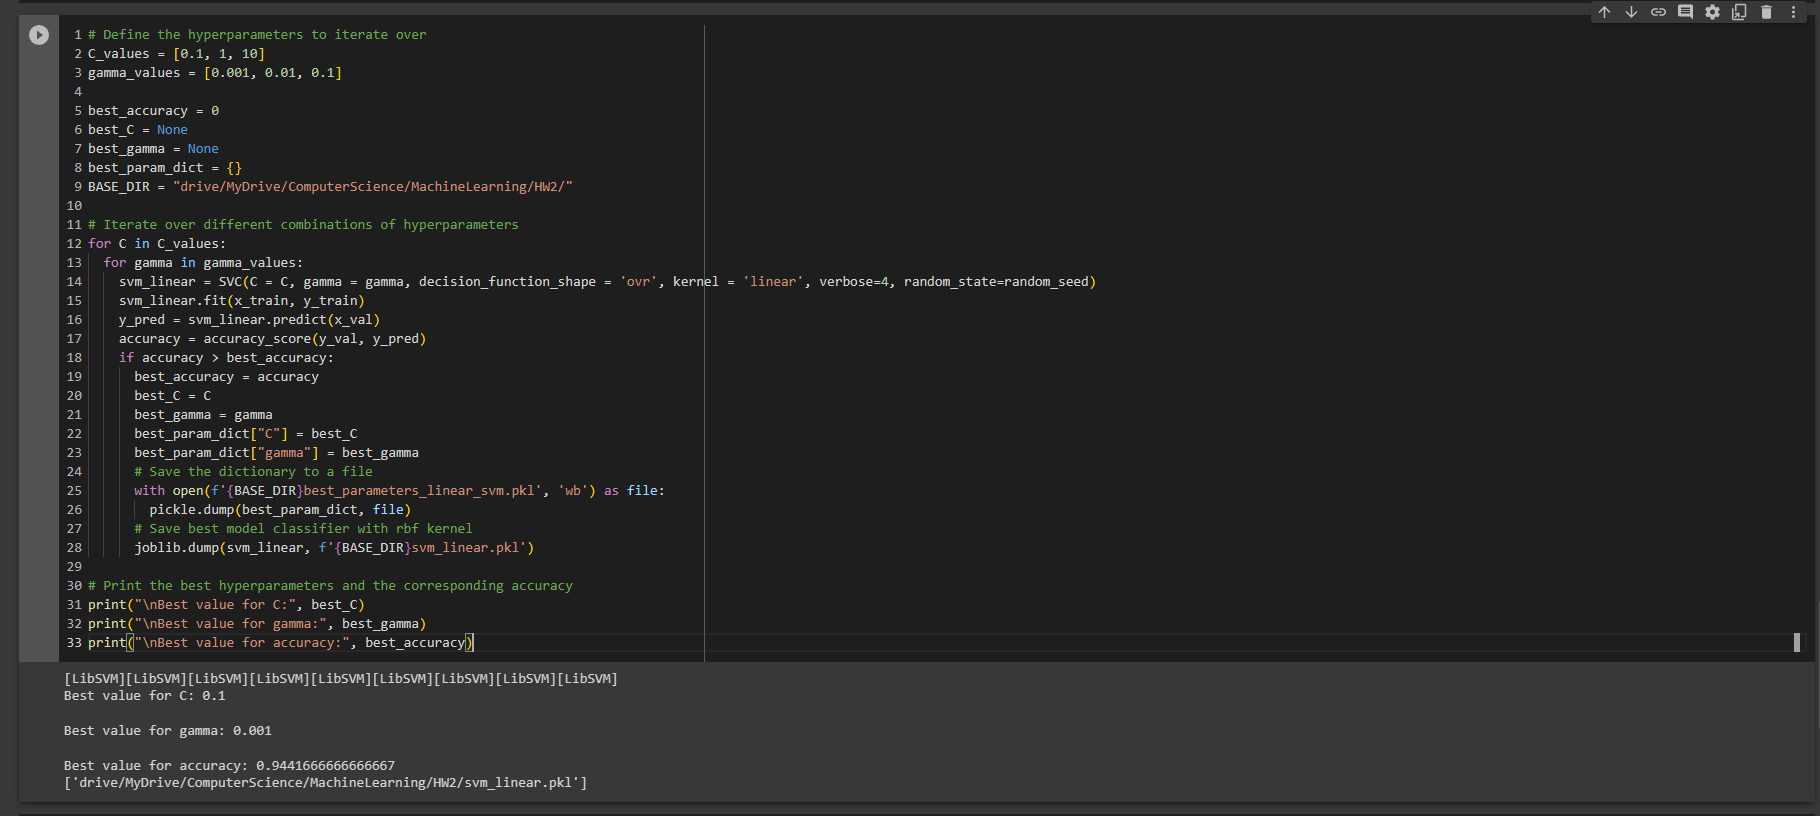

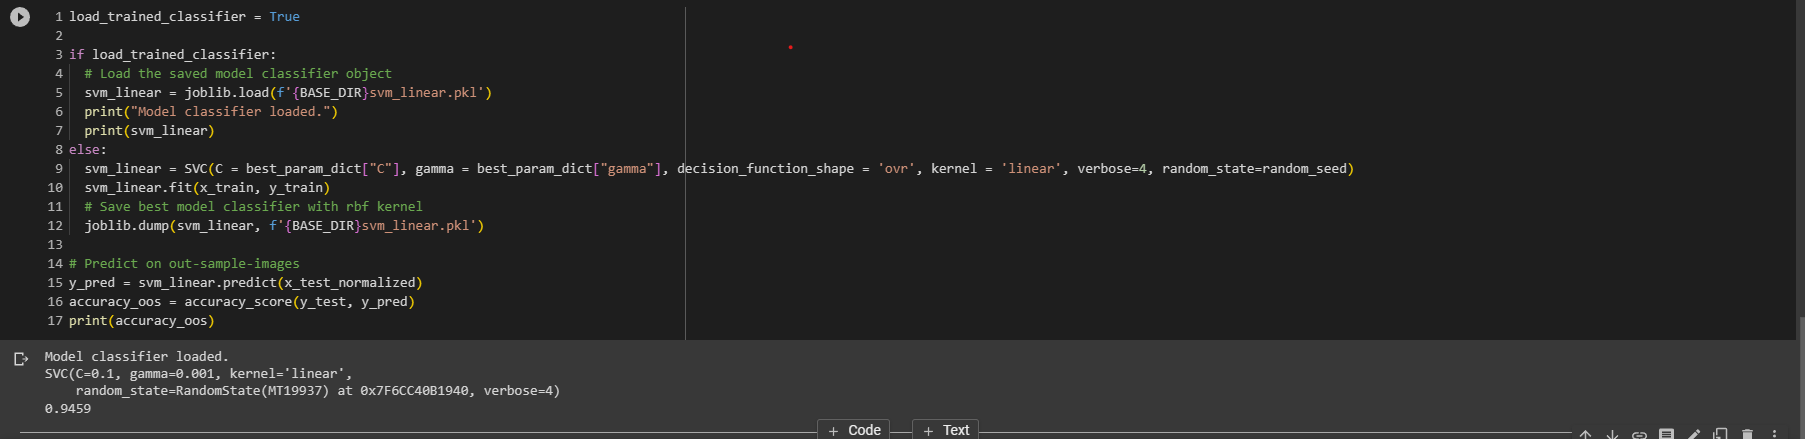

Accuracy on validation dataset: 0.9441666666666667 </br>
Best parameters: C = 0.1, gamma: 0.001 </br>
Accuracy on test dataset: 0.9459 </br>

The accuracy of the *Linear* kernel is similar on both training and test samples (~ 0.945). However, the training process is very high (~ 1 hour) due to the computational expensive dataset of 784 features.

---

Total time of execution for *RBF* kernel with 9 total models: ~3 hours </br>
Total time of execution for *Linear* kernel with 9 total models: ~1 hour

The Linear kernel SVM converged much faster than the RBF kernel SVM, with the latter achieving better results over the test/out-of-sample images compared to the former SVM model.

PCA (Principal Component Analysis)
---

Let's first select three different values for the explained variance

In [ ]:
explained_variance_thresholds = [0.65, 0.80, 0.95] #split the variance into 3 buckets with 15% difference

SVM with *RBF* kernel

In [ ]:
for variance in explained_variance_thresholds:
  # Apply PCA transformation on the normalized data samples.
  pca = PCA(n_components=variance).fit(x_train)

  # Fit and transform the data based on the instantiated PCA object.
  x_train_pca = pca.transform(x_train)
  x_test_pca = pca.transform(x_test_normalized)

  # Print the number of components and the corresponding explained variance ratio.
  print(f"Number of components: {pca.n_components_}")
  print(f"Explained variance ratio: {pca.explained_variance_ratio_.cumsum()[-1]}")

  # Load the saved model classifier object.
  svm = joblib.load(f'{BASE_DIR}svm_rbf.pkl')
  print("Model classifier loaded")
  print("\n")
  print(svm)
  start_time = time.time()

  # Fit the model on the X_train_transformed data (x_train after applying PCA reduction technique)
  svm.fit(x_train_pca, y_train)
  # Predict on out-sample-images
  y_pred = svm.predict(x_test_pca)
  accuracy_oos = accuracy_score(y_test, y_pred)
  print(f"\nAccuracy score on out-of-sample images: {accuracy_oos}")
  
  end_time = time.time()
  elapsed_time = end_time - start_time
  print(f"\nExecution time of fit(), predict() methods: {datetime.timedelta(seconds=elapsed_time)}")
  print("\n---------------------------------------------------------------------------------------------------")

Number of components: 21
Explained variance ratio: 0.654058348038556
Model classifier loaded


SVC(C=10, gamma=0.01, random_state=RandomState(MT19937) at 0x7FC7510CB940,
    verbose=4)
[LibSVM]
Accuracy score on out-of-sample images: 0.9755

Execution time of fit(), predict() methods: 0:00:18.191308

---------------------------------------------------------------------------------------------------
Number of components: 44
Explained variance ratio: 0.8031761084826367
Model classifier loaded


SVC(C=10, gamma=0.01, random_state=RandomState(MT19937) at 0x7FC7510CB840,
    verbose=4)
[LibSVM]
Accuracy score on out-of-sample images: 0.9834

Execution time of fit(), predict() methods: 0:00:29.868549

---------------------------------------------------------------------------------------------------
Number of components: 154
Explained variance ratio: 0.9501544969236339
Model classifier loaded


SVC(C=10, gamma=0.01, random_state=RandomState(MT19937) at 0x7FC7510CBA40,
    verbose=4)
[LibSVM]

SVM with *Linear* kernel

In [ ]:
for variance in explained_variance_thresholds:
  # Apply PCA transformation on the normalized data samples.
  pca = PCA(n_components=variance).fit(x_train)

  # Fit and transform the data based on the instantiated PCA object.
  x_train_pca = pca.transform(x_train)
  x_test_pca = pca.transform(x_test_normalized)

  # Print the number of components and the corresponding explained variance ratio.
  print(f"Number of components: {pca.n_components_}")
  print(f"Explained variance ratio: {pca.explained_variance_ratio_.cumsum()[-1]}")

  # Load the saved model classifier object.
  svm = joblib.load(f'{BASE_DIR}svm_linear.pkl')
  print("Model classifier loaded")
  print("\n")
  print(svm)
  start_time = time.time()

  # Fit the model on the x_train_pca data (x_train after applying PCA reduction technique)
  svm.fit(x_train_pca, y_train)
  # Predict on out-sample-images
  y_pred = svm.predict(x_test_pca)
  accuracy_oos = accuracy_score(y_test, y_pred)
  print(f"\nAccuracy score on out-of-sample images: {accuracy_oos}")
  
  end_time = time.time()
  elapsed_time = end_time - start_time
  print(f"\nExecution time of fit(), predict() methods: {datetime.timedelta(seconds=elapsed_time)}")
  print("\n---------------------------------------------------------------------------------------------------")

Number of components: 21
Explained variance ratio: 0.654058348038556
Model classifier loaded


SVC(C=0.1, gamma=0.001, kernel='linear',
    random_state=RandomState(MT19937) at 0x7FC7510CB940, verbose=4)
[LibSVM]
Accuracy score on out-of-sample images: 0.9127

Execution time of fit(), predict() methods: 0:00:26.064350

---------------------------------------------------------------------------------------------------
Number of components: 44
Explained variance ratio: 0.8031761084826367
Model classifier loaded


SVC(C=0.1, gamma=0.001, kernel='linear',
    random_state=RandomState(MT19937) at 0x7FC7510CBA40, verbose=4)
[LibSVM]
Accuracy score on out-of-sample images: 0.9348

Execution time of fit(), predict() methods: 0:00:37.471941

---------------------------------------------------------------------------------------------------
Number of components: 154
Explained variance ratio: 0.9501544969236339
Model classifier loaded


SVC(C=0.1, gamma=0.001, kernel='linear',
    random_state=Ra

Gathering and commenting on the experiment results
---

<u>**RBF** kernel</u></br>
Features: 784</br>
Accuracy (test sample): 0.9811</br>
Total complition (train 1 model): 20-25 minutes

---
Features: 21</br>
Accuracy (test sample): 0.9755</br>
Total complition: 18 seconds

---
Features: 44</br>
Accuracy (test sample): 0.9834</br>
Total complition: 29 seconds

---
Features: 154</br>
Accuracy (test sample): 0.9812</br>
Total complition: 1m 07s

There is a clear tradeoff between number of total components/features used in training and the model execution time. The more the features used the higher the total time to complete `model.fit()`. The accuracy on the other hand is not affected when decreasing the total number of components from 784 to 44 (5.6% of features). By using for training only the 6% of total features I have achieved a greater accuracy on test samples.
Thus, PCA indeed had a positive effect on the model's predictive performance and execution time.

<u>**Linear** kernel</u></br>
Features: 784</br>
Accuracy (test sample): 0.9459</br>
Total complition (train 1 model): 7 minutes

---
Features: 21</br>
Accuracy (test sample): 0.9127</br>
Total complition: 26 seconds

---
Features: 44</br>
Accuracy (test sample): 0.9348</br>
Total complition: 37 seconds

---
Features: 154</br>
Accuracy (test sample): 0.9455</br>
Total complition: 58 seconds


Again, there is a clear tradeoff between number of total components/features used in training and the model execution time. The more the features used the higher the total time to complete `model.fit()`. The accuracy on the other hand is not affected when decreasing the total number of components from 784 to 44 (5.6% of features). By using for training only the 6% of total features I have achieved almost the same accuracy on test samples.
Thus, PCA indeed had a positive effect on the model's execution time when the *linear* kernel was used.

Overall, **RBF** kernel had the best results with **44** components/features explaining **80%** of the training samples variance and achieving **98.3%** of accuracy on test samples after only 29 seconds of model training.